In [ ]:
!pip install scikit-maad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 5.4 MB/s 
     |████████████████████████████████| 38.1 MB 2.1 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from librosa import feature
from maad import sound
from time import time
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


sns.set_theme()
plt.rcParams["figure.figsize"] = (17, 5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%% Set variables
path_annotations = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio_labels.csv'  # manual annotations in csv table
path_audio = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio/'  # directory where the audio data is located
path_results = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/results/'
target_fs = 10000  # set target sampling rate for audio

In [ ]:
#%% Load annotations
df = pd.read_csv(path_annotations)  

In [ ]:
df.shape

(1104, 7)

In [ ]:
df.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav


In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

classifier = LogisticRegression(penalty='l1',class_weight='balanced',max_iter=2666,solver='saga')

# Pipeline, should we normalize/standarize?
pipe = Pipeline ([#("cleaner", predictors()),
                 #("standarize", ),
                 ("classifier", classifier)])

# Classifiers to use
clfs = [LinearSVC(class_weight='balanced',max_iter=2666, random_state=0, tol=1e-5),
        SGDClassifier(class_weight='balanced',max_iter=2666, tol=1e-3),
        SVC(kernel='rbf',degree=3,gamma='scale',class_weight='balanced'),
        LogisticRegression(penalty='l1',class_weight='balanced',max_iter=2666,solver='saga'),
        DecisionTreeClassifier(class_weight='balanced'),
        RandomForestClassifier(class_weight='balanced'),
        GradientBoostingClassifier()]

In [ ]:
#%% Compute features
df_features = pd.DataFrame()

scores = {"Method":[],
          "Features": [],
          "Feature Extraction Time":[],
          "Metric Score":[],
          "Performance": [],
          "Classifier Time":[],
          }

scoring = ["f1", "balanced_accuracy","roc_auc"]
#%% Compute features
df_features = pd.DataFrame()
# Calculate for each feature, time of extraction

for idx_row, row in df.iterrows():
    t0_features = time()
    full_path_audio = os.path.join(path_audio, row.sample_idx)
    s, fs = sound.load(full_path_audio)
    # resample
    s_resamp = sound.resample(s, fs, target_fs, res_type='kaiser_fast')
    # transform
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = feature.mfcc(y=s_resamp, sr=target_fs, n_mfcc=20, n_fft=1024, 
                        win_length=1024, hop_length=512, htk=True)
    mfcc = np.median(mfcc, axis=1)
    # format dataframe
    idx_names = ['mfcc_' + str(idx).zfill(2) for idx in range(1,mfcc.size+1)]
    row = row.append(pd.Series(mfcc, index=idx_names))
    row.name = idx_row
    df_features = df_features.append(row)
  

duration = round(time() - t0_features,2)
scores["Feature Extraction Time"].extend([duration]*len(clfs)*n_splits*len(scoring))
print('Feature:', 'Extraction Time:',duration)
scores["Features"].extend(['mfcc']*len(clfs)*n_splits*len(scoring))

#%% Split development and test data
X = df_features.loc[:,df_features.columns.str.startswith('mfcc')]
y = (df_features.label=='LLUVIA').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42) 
for classifier in tqdm(clfs):
      print('-----------------------------------')
      t0 = time()
      print(str(classifier))
      pipe.set_params(classifier = classifier)
      cv_result = cross_validate(pipe, X_train, y_train, scoring=scoring,cv=skf)
      
      metrics = [i for i in cv_result.keys() if 'test' in i]
      n_metrics = len(metrics)

      for metric in metrics:
          scores["Performance"].extend(cv_result[metric])
          scores["Metric Score"].extend([metric.split('test_')[-1]]*n_splits)
          scores["Method"].extend([str(classifier).split('(')[0]]*n_splits)
      print('---------------------------------')
      duration = round(time() - t0,2)
      scores["Classifier Time"].extend([duration]*n_metrics*n_splits)
      print('duration:',duration)
      for key, values in cv_result.items():
              print(key,' mean ', values.mean())
              print(key,' std ', values.std())

      #save in each running to avoid execution without saving
                
df_scores = pd.DataFrame(scores)
df_scores.to_csv(path_results+'results.csv',index=False) ## ad descriptive name a nd date

Feature: Extraction Time: 0.21


  0%|          | 0/7 [00:00<?, ?it/s]

-----------------------------------
LinearSVC(class_weight='balanced', max_iter=2666, random_state=0, tol=1e-05)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
 14%|█▍        | 1/7 [00:00<00:03,  1.85it/s]

---------------------------------
duration: 0.54
fit_time  mean  0.09443950653076172
fit_time  std  0.010298856323484847
score_time  mean  0.010050725936889649
score_time  std  0.0014128132866310505
test_f1  mean  0.732327370440229
test_f1  std  0.054318558546961174
test_balanced_accuracy  mean  0.8131572187391154
test_balanced_accuracy  std  0.04530462292582271
test_roc_auc  mean  0.9519074999274352
test_roc_auc  std  0.016257071665952787
-----------------------------------
SGDClassifier(class_weight='balanced', max_iter=2666)
---------------------------------
duration: 0.09
fit_time  mean  0.007742643356323242
fit_time  std  0.0035949482077405185
score_time  mean  0.009186697006225587
score_time  std  0.005301973044118984
test_f1  mean  0.6859558881360883
test_f1  std  0.1361949461877029
test_balanced_accuracy  mean  0.8388671194705678
test_balanced_accuracy  std  0.07108215014131582
test_roc_auc  mean  0.9524264102954836
test_roc_auc  std  0.01985525691459682
-----------------------

 43%|████▎     | 3/7 [00:00<00:00,  4.16it/s]

---------------------------------
duration: 0.17
fit_time  mean  0.017250490188598634
fit_time  std  0.006247002507074487
score_time  mean  0.014305925369262696
score_time  std  0.0021198509320360733
test_f1  mean  0.7555375298473891
test_f1  std  0.03818699804340067
test_balanced_accuracy  mean  0.8842574451410659
test_balanced_accuracy  std  0.020545317725223434
test_roc_auc  mean  0.9626024976779288
test_roc_auc  std  0.011329224595321286
-----------------------------------
LogisticRegression(class_weight='balanced', max_iter=2666, penalty='l1',
                   solver='saga')


 71%|███████▏  | 5/7 [00:03<00:01,  1.52it/s]

---------------------------------
duration: 2.21
fit_time  mean  0.433763313293457
fit_time  std  0.0982470229211
score_time  mean  0.006290817260742187
score_time  std  0.0001524063311692448
test_f1  mean  0.7687927927927929
test_f1  std  0.035775345348357614
test_balanced_accuracy  mean  0.8952059386973181
test_balanced_accuracy  std  0.028704027828421255
test_roc_auc  mean  0.9629542461250434
test_roc_auc  std  0.007514377892877245
-----------------------------------
DecisionTreeClassifier(class_weight='balanced')
---------------------------------
duration: 0.11
fit_time  mean  0.01179642677307129
fit_time  std  0.0004491740072377587
score_time  mean  0.006174230575561523
score_time  std  9.276494050798692e-05
test_f1  mean  0.7105132850241546
test_f1  std  0.08660971586364259
test_balanced_accuracy  mean  0.819856757227447
test_balanced_accuracy  std  0.058571986459785605
test_roc_auc  mean  0.8198567572274469
test_roc_auc  std  0.05857198645978556
---------------------------------

 86%|████████▌ | 6/7 [00:04<00:00,  1.07it/s]

---------------------------------
duration: 1.52
fit_time  mean  0.267299222946167
fit_time  std  0.015279671606697211
score_time  mean  0.03260021209716797
score_time  std  0.0014778115359158728
test_f1  mean  0.8175266792215943
test_f1  std  0.04700740683803054
test_balanced_accuracy  mean  0.8628252351097178
test_balanced_accuracy  std  0.03483057385467016
test_roc_auc  mean  0.9725527182747011
test_roc_auc  std  0.01283358255784412
-----------------------------------
GradientBoostingClassifier()


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]

---------------------------------
duration: 2.5
fit_time  mean  0.4889185905456543
fit_time  std  0.00992498117303668
score_time  mean  0.008245515823364257
score_time  std  0.0011679983975240993
test_f1  mean  0.8136878530717769
test_f1  std  0.031571408602907254
test_balanced_accuracy  mean  0.8762865726227795
test_balanced_accuracy  std  0.025228211229031933
test_roc_auc  mean  0.9622695888482526
test_roc_auc  std  0.01760184425884631


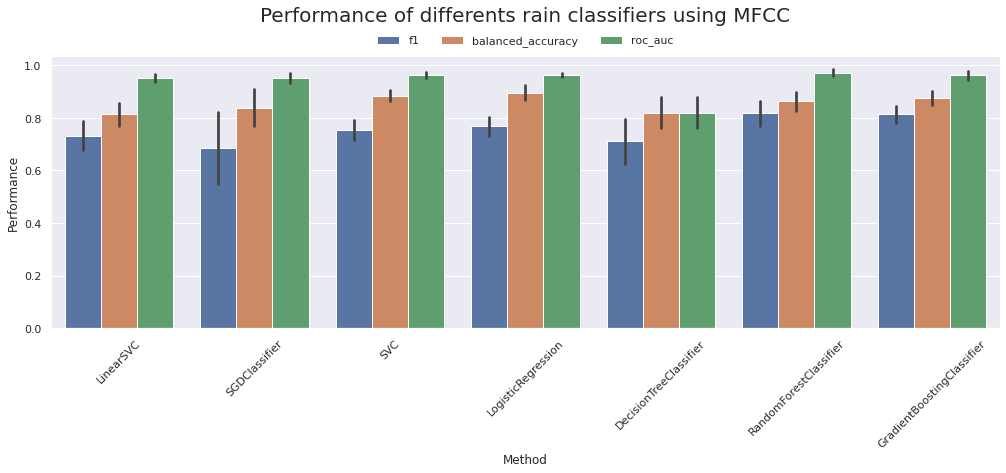

In [ ]:
ax = sns.barplot(data=df_scores,x='Method',y='Performance',hue='Metric Score',ci="sd")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.set_title('Performance of differents rain classifiers using MFCC', fontdict = {'fontsize' : 20}, pad=35)
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Time Performance of differents rain classifiers using MFCC')

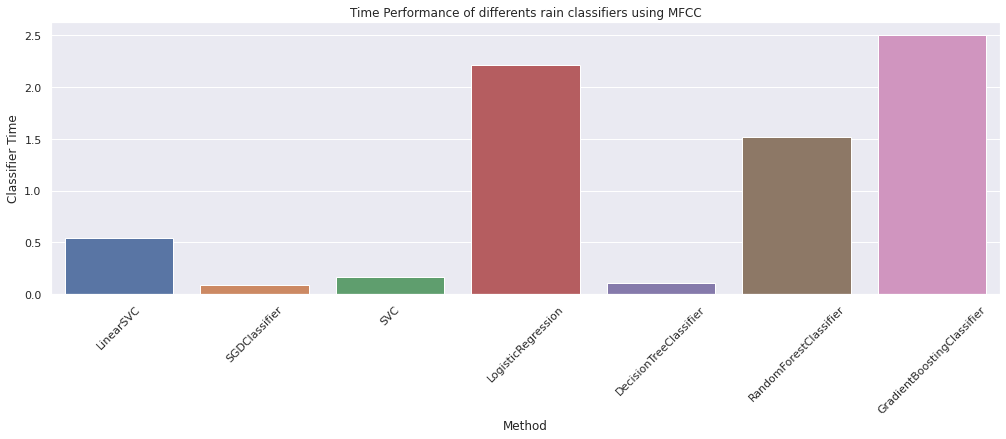

In [ ]:
sns.barplot(data=df_scores,x='Method',y='Classifier Time')
plt.xticks(rotation=45)
plt.title('Time Performance of differents rain classifiers using MFCC')

In [ ]:
df_scores.groupby(['Method','Metric Score'])['Performance'].agg(['mean', 'std'])

mean       std
Method                     Metric Score                         
DecisionTreeClassifier     balanced_accuracy  0.819857  0.065485
                           f1                 0.710513  0.096833
                           roc_auc            0.819857  0.065485
GradientBoostingClassifier balanced_accuracy  0.876287  0.028206
                           f1                 0.813688  0.035298
                           roc_auc            0.962270  0.019679
LinearSVC                  balanced_accuracy  0.813157  0.050652
                           f1                 0.732327  0.060730
                           roc_auc            0.951907  0.018176
LogisticRegression         balanced_accuracy  0.895206  0.032092
                           f1                 0.768793  0.039998
                           roc_auc            0.962954  0.008401
RandomForestClassifier     balanced_accuracy  0.862825  0.038942
                           f1                 0.817527  0.052556
                           roc_auc            0.972553  0.014348
SGDClassifier              balanced_accuracy  0.838867  0.079472
                           f1                 0.685956  0.152271
                           roc_auc            0.952426  0.022199
SVC                        balanced_accuracy  0.884257  0.022970
                           f1                 0.755538  0.042694
                           roc_auc            0.962602  0.012666

In [ ]:
df_features.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx,mfcc_01,mfcc_02,mfcc_03,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav,-364.480284,14.626889,-9.040904,...,-13.825317,11.294139,-8.473920,5.585907,-4.071078,3.079958,-2.595304,1.238552,-1.273726,2.189629
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav,-459.676892,23.274923,29.334150,...,-26.792982,15.893755,-16.913697,7.601939,-9.066683,1.031880,-2.732603,-1.687596,1.850289,0.888578
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav,-430.154709,12.203873,39.103408,...,-30.930512,10.762661,-18.298168,6.209497,-5.108315,2.914322,4.538830,1.821480,6.642914,3.535639
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav,-461.207384,9.153970,35.270469,...,-22.553684,13.269162,-9.360821,0.024768,1.678963,-7.180969,5.397620,-7.151477,3.316897,-0.835616
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav,-442.703396,8.661459,22.384752,...,-20.938217,12.807910,-8.824346,1.402457,0.011821,-4.124073,2.397523,-4.001880,2.880554,-1.047842


In [ ]:
df_features['lluvia'] = df_features['label'].apply(lambda x: 'Rain' if x=='LLUVIA' else 'No Rain')

In [ ]:
df_features['label'].unique()

array(['SENSAT', 'MURCIE', 'INSECT', 'LLUVIA', 'PULSOS', 'HERPET',
       'ANTROP', 'AVEVOC', 'TRAMOT', 'INDETE', 'PASOS', 'FLUAGU',
       'ANIDOM'], dtype=object)

In [ ]:
df_features['label_english'] = df_features['label'].replace({'SENSAT':'Saturated',
                                                    'MURCIE':'Bats',
                                                    'INSECT':'Insects',
                                                    'LLUVIA':'Rain',
                                                    'PULSOS':'Pulses', 
                                                    'HERPET':'Amphibian',
                                                    'ANTROP':'Anthrophony',
                                                    'AVEVOC':'Birds', 
                                                    'TRAMOT':'Motors',#'Transporte Motorizado', 
                                                    'INDETE':'Undetermined', 
                                                    'PASOS': 'Footsteps', #'Pasos', 
                                                    'FLUAGU':'Rainfall',
                                                    'ANIDOM': 'Domestic Animals' #'Animales Domésticos'
                                                     })

df_features['soundscape_label'] = df_features['label'].replace({
                                                        'SENSAT':'Other',
                                                        'MURCIE':'Biophony',
                                                        'INSECT':'Biophony',
                                                        'LLUVIA':'Geophony',
                                                        'PULSOS':'Other', 
                                                        'HERPET':'Biophony',
                                                        'ANTROP':'Anthrophony',
                                                        'AVEVOC':'Biophony', 
                                                        'TRAMOT':'Anthrophony', 
                                                        'INDETE':'Other', 
                                                        'PASOS': 'Anthrophony',
                                                        'FLUAGU':'Geophony',
                                                        'ANIDOM': 'Anthrophony'
                                                    })

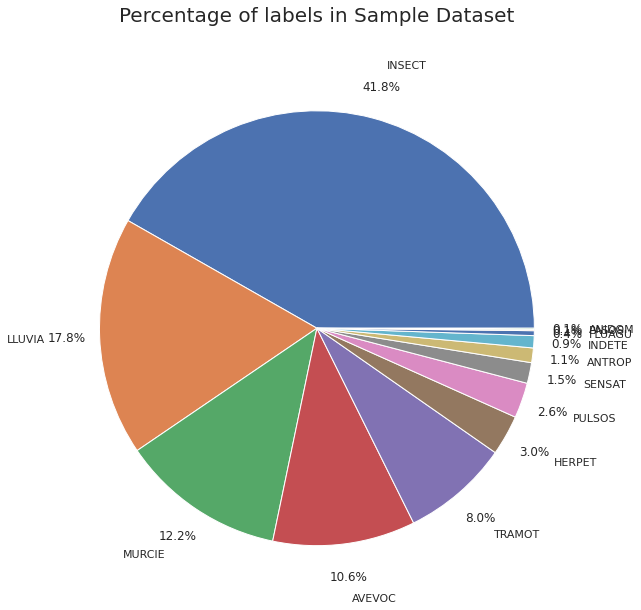

In [ ]:
# plot inside big category
plt.figure(figsize=(27, 10))
ax = df_features['label'].value_counts().plot.pie(autopct='%1.1f%%',pctdistance=1.15, labeldistance=1.25,)
ax.set_title("Percentage of labels in Sample Dataset", fontdict = {'fontsize' : 20}, pad=35)
plt.axis('off')
plt.show()

In [ ]:
df_features_plot = df_features.groupby(['soundscape_label','label_english'])['fname'].count().to_frame().reset_index()

In [ ]:
fig = px.sunburst(df_features_plot, path=[ 'soundscape_label','label_english' ], values='fname',template='seaborn',width=800, height=800)
fig.update_traces(textinfo="label+value")
fig.show()

In [ ]:
df_features['fname'].str[:4].value_counts()

G089    35
G092    34
G010    33
G093    30
G002    26
        ..
G043     5
G017     5
G039     5
G080     5
G022     3
Name: fname, Length: 97, dtype: int64

In [ ]:
len(df_features['label'].unique())

13

In [ ]:
df_features.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx,mfcc_01,mfcc_02,mfcc_03,...,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,lluvia,label_english,soundscape_label
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav,-364.480284,14.626889,-9.040904,...,5.585907,-4.071078,3.079958,-2.595304,1.238552,-1.273726,2.189629,No Rain,Saturated,Other
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav,-459.676892,23.274923,29.334150,...,7.601939,-9.066683,1.031880,-2.732603,-1.687596,1.850289,0.888578,No Rain,Bats,Biophony
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav,-430.154709,12.203873,39.103408,...,6.209497,-5.108315,2.914322,4.538830,1.821480,6.642914,3.535639,No Rain,Insects,Biophony
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav,-461.207384,9.153970,35.270469,...,0.024768,1.678963,-7.180969,5.397620,-7.151477,3.316897,-0.835616,No Rain,Bats,Biophony
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav,-442.703396,8.661459,22.384752,...,1.402457,0.011821,-4.124073,2.397523,-4.001880,2.880554,-1.047842,No Rain,Saturated,Other


In [ ]:
df_features['fname'].str[:4].value_counts().describe()

count    97.000000
mean     11.381443
std       7.071721
min       3.000000
25%       6.000000
50%       8.000000
75%      16.000000
max      35.000000
Name: fname, dtype: float64

In [ ]:
#%% Tune model hyperparameters
clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample')


# Set tuning strategy
param_grid = {'n_estimators' : [1, 5, 10, 100, 300, 500],
              'max_features' : [2, 6, 10, 14, 18]}

skf = StratifiedKFold(n_splits=10)
clf_gs = GridSearchCV(clf, param_grid, scoring=['f1'], 
                           refit='f1', cv=skf, return_train_score=True,
                           n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
#%% Evaluation: compute metrics, error analysis
print('Mean cross-validated score of the best_estimator:', clf_gs.best_score_)
print('Parameter setting that gave the best results on hold out data', clf_gs.best_params_)

Mean cross-validated score of the best_estimator: 0.8336116260865982
Parameter setting that gave the best results on hold out data {'max_features': 10, 'n_estimators': 300}


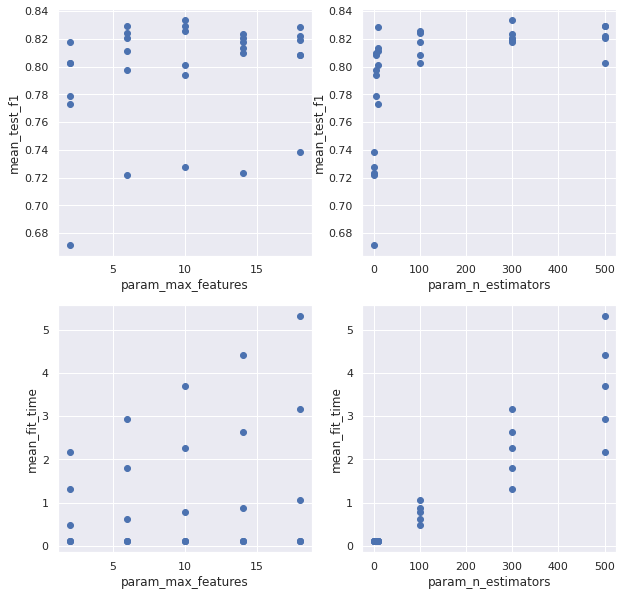

In [ ]:
# Plots to explore results of cross-validation
params = ['param_max_features', 'param_n_estimators']
metrics = ['mean_test_f1', 'mean_fit_time']
fig, ax = plt.subplots(2,2, figsize=[10,10])

ax[0,0].plot(clf_gs.cv_results_[params[0]].tolist(), clf_gs.cv_results_[metrics[0]], 'o')
ax[0,0].set_xlabel(params[0]); ax[0,0].set_ylabel(metrics[0]);

ax[0,1].plot(clf_gs.cv_results_[params[1]].tolist(), clf_gs.cv_results_[metrics[0]], 'o')
ax[0,1].set_xlabel(params[1]); ax[0,1].set_ylabel(metrics[0]);

ax[1,0].plot(clf_gs.cv_results_[params[0]].tolist(), clf_gs.cv_results_[metrics[1]], 'o')
ax[1,0].set_xlabel(params[0]); ax[1,0].set_ylabel(metrics[1]);

ax[1,1].plot(clf_gs.cv_results_[params[1]].tolist(), clf_gs.cv_results_[metrics[1]], 'o')
ax[1,1].set_xlabel(params[1]); ax[1,1].set_ylabel(metrics[1]);



In [ ]:
#%% Final evaluation on test data
y_pred = clf_gs.predict(X_test)
score = f1_score(y_test, y_pred)

In [ ]:
score

0.8253968253968255